<a href="https://colab.research.google.com/github/TsvetaIvanova/ColabIMLO/blob/main/OffIMLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running instructions

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

## imports

In [ ]:
import pandas as pd
from sklearn import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, transforms
import time
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from google.colab import runtime
from google.colab import drive
from torchsummary import summary
from torchviz import make_dot
from torchvision.transforms import v2
from collections import Counter


#Get full dataset into dataframe


In [ ]:
print(torch.__version__)
# !pip install torch==2.2.2

2.3.0+cu121


# Get and process data


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The neural network is currently training on a {device} device")

The neural network is currently training on a cuda device


In [ ]:

data_train_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(50),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


data_val_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


data_test_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
train_set = datasets.Flowers102(root='data', split='train', download=True, transform=data_train_transform)
test_set = datasets.Flowers102(root='data', split='test', download=True, transform=data_test_transform)
val_set = datasets.Flowers102(root='data', split='val', download=True, transform=data_val_transform)


# data loaders
train_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_set, batch_size=16, shuffle=False)


100%|██████████| 344862509/344862509 [00:02<00:00, 162345561.13it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1713214.49it/s]


100%|██████████| 14989/14989 [00:00<00:00, 23723933.08it/s]


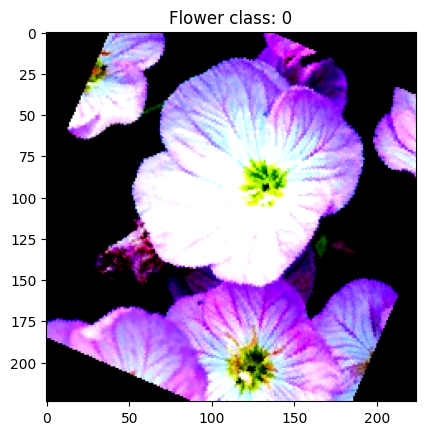

In [ ]:
def show_image(dataset, index=0):
    image, class_flower = dataset[index]
    image = image.clamp(0, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f'Flower class: {class_flower}')
    plt.show()
# show_image(train_set)

## define the model

In [ ]:

class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 102)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        #print(x.shape)
        x = x.view(-1, 512 * 14 * 14)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [ ]:
training_accuracies = []
training_losses = []
validation_accuracies = []
validation_losses = []
test_accuracies = []

In [ ]:
# Training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
        total += y.size(0)

    average_loss = total_loss / len(dataloader)
    accuracy = correct / total * 100
    training_losses.append(average_loss)
    training_accuracies.append(accuracy)
    print(f"Training Loss: {average_loss:.4f}, Training Accuracy: {accuracy:.2f}%")

In [ ]:
# Testing function
def test(dataloader, model, loss_fn, label="Validation"):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)

    average_loss = total_loss / len(dataloader)
    accuracy = correct / total * 100
    if label == "Validation":
        validation_losses.append(average_loss)
        validation_accuracies.append(accuracy)
    print(f"{label} Loss: {average_loss:.4f}, {label} Accuracy: {accuracy:.2f}%")
    return average_loss




In [ ]:
model = ConvNeuralNetwork().to(device)
summary(model, (3, 224, 224))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
       BatchNorm2d-5        [-1, 128, 112, 112]             256
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
       BatchNorm2d-8          [-1, 256, 56, 56]             512
         MaxPool2d-9          [-1, 256, 28, 28]               0
           Conv2d-10          [-1, 512, 28, 28]       1,180,160
      BatchNorm2d-11          [-1, 512, 28, 28]           1,024
        MaxPool2d-12          [-1, 512, 14, 14]               0
           Linear-13                 [-1, 1024]     102,761,472
      BatchNorm1d-14                 [-

In [ ]:
# LossFN
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)




# Train and Evaluation


In [ ]:
def create_and_save_dataframe():
    if len(training_accuracies) == len(validation_accuracies):
        df_training = pd.DataFrame({
            'Epoch': range(1, epochs+1),
            'Training Accuracy': training_accuracies,
            'Training Loss': training_losses,
            'Validation Accuracy': validation_accuracies,
            'Validation Loss': validation_losses
        })
        df_training.to_csv('training_validation_metrics.csv', index=False)
        print(df_training)
    else:
        print("maybe I have some differences in column lengths?")


In [ ]:
# Training and evaluation loop
epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1},\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val_loss = test(val_loader, model, loss_fn)
    scheduler.step(val_loss)

    # Checkpointing every 100 epochs
    if t % 100 == 0 and t != 0:
        torch.save(model.state_dict(), f'model_epoch_{t}.pth')
        print(f'Checkpoint epoch {t}')

print("This marks the end of training the model, now commences the eval stage on the test data")
create_and_save_dataframe()

Epoch 1,
-------------------------------
Training Loss: 4.5624, Training Accuracy: 3.92%
Validation Loss: 3.8533, Validation Accuracy: 15.88%
Epoch 2,
-------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Loss: 3.8594, Training Accuracy: 10.49%
Validation Loss: 3.5209, Validation Accuracy: 21.86%
Epoch 3,
-------------------------------
Training Loss: 3.4897, Training Accuracy: 18.53%
Validation Loss: 3.2578, Validation Accuracy: 24.90%
Epoch 4,
-------------------------------
Training Loss: 3.2255, Training Accuracy: 22.65%
Validation Loss: 3.0224, Validation Accuracy: 29.90%
Epoch 5,
-------------------------------
Training Loss: 2.9556, Training Accuracy: 26.47%
Validation Loss: 2.9460, Validation Accuracy: 31.27%
Epoch 6,
-------------------------------
Training Loss: 2.7739, Training Accuracy: 32.06%
Validation Loss: 2.7965, Validation Accuracy: 36.27%
Epoch 7,
-------------------------------
Training Loss: 2.5732, Training Accuracy: 36.67%
Validation Loss: 2.7294, Validation Accuracy: 36.47%
Epoch 8,
-------------------------------
Training Loss: 2.4017, Training Accuracy: 40.00%
Validation Loss: 2.6141, Validation Accuracy: 40.69%
Epoch 9,
-------------------------------

## split and format the dataset

## Create a checkpoint for the training and testing in case I have to pause

## Create a visualisation

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Evaluation has to go in separate python

In [ ]:
model = ConvNeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

# Eval

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Evaluation loop
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')
accuracy = correct / total * 100
test_accuracies.append(accuracy)
print(f"Test Accuracy: {accuracy:.2f}%")

# Create DataFrames
df_training = pd.DataFrame({
    'Epoch': range(1, epochs+1),
    'Training Accuracy': training_accuracies,
    'Training Loss': training_losses,
    'Validation Accuracy': validation_accuracies,
    'Validation Loss': validation_losses,
})

# Save DataFrames to CSV
df_training.to_csv('training_validation_metrics.csv', index=False)
print(df_training)

# Save test accuracies to CSV
df_test = pd.DataFrame({
    'Test Accuracy': test_accuracies
})
df_test.to_csv('test_metrics.csv', index=False)
print(df_test)

